<font color='green'> Normalized Nerd - Youtube kanalında [Naive Bayes Classifier in Python (from scratch!)](https://www.youtube.com/watch?v=3I8oX3OUL6I) videosunda sıfırdan Naive Bayes Classifier modeli oluşturuldu. </font> 

## <font color='black'> İçindekiler</font>

**Naive Bayes Classifier Teori Özet**

**Naive Bayes Classifier Uygulama**
1. Target değişkenimizin nasıl dağıldığına bakıyoruz.
2. Featureların independent olup olmadığına bakıyoruz. Dependent olanları datadan çıkartıyoruz.
3. Featurelarımızın histogramını çiziyoruz.
4. Veriyi Bir Dağılıma Fit Ederek Continuous Verilerden Kurtulma
    - Tüm y classları için (0,1) P(Y=y) olasılık hesaplamalarını yapıyoruz.
    - Normal dağılımı kullanarak likelihood hesaplaması yapıyoruz.
    - Tüm y değerleri için formüldeki pay değerini hesaplıyoruz. `P(X=x1|Y=y)P(X=x2|Y=y)...P(X=xn|Y=y) * P(Y=y)`
    - Modelimizi test ediyoruz.
5. Continuous Değişkenleri Kategorik Değişkenlere Çevirerek Continuous Değerlerden Kurtulma
    - Tüm y classları için (0,1) P(Y=y) olasılık hesaplamalarını yapıyoruz.
    - Likelihood hesaplaması P(X=x|Y=y) yapıyoruz.
    - Tüm y değerleri için formüldeki pay değerini hesaplıyoruz. `P(X=x1|Y=y)P(X=x2|Y=y)...P(X=xn|Y=y) * P(Y=y)`
    - Modelimizi test ediyoruz.

# <font color='black'> Naive Bayes Classifier in Python from scratch</font>

## <font color='blue'> Naive Bayes Classifier Teori Özet</font>

Elimizde bir X ve Y vektörü var. Y 0 ve 1 olmak üzere iki değer alabiliyor. Bu X feature vektörü için en olası Y classını bulmaya çalışıyoruz. Bayes teoremini kullanıyoruz bu noktada. Bayes teoremine göre X verildiğinde Y'nin olasılığı; (likelihood * prior) /evidence şeklinde hesaplanıyor. Burada P(Y|X) değerini maksimum yapan Y değerini bulmak istiyoruz.

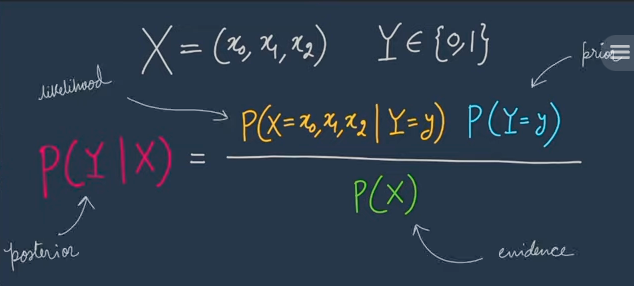

Bunu bulmak için evidence'i görmezden geliyoruz. Çünkü bunun Y ile bağlantısı yok ve hesaplaması genelde zordur. Onun için sadece payı maksimize etmeye çalışıp hangi y değerinde P(Y=y|X)'nin maksimum olduğunu bulmaya çalışıyoruz.  

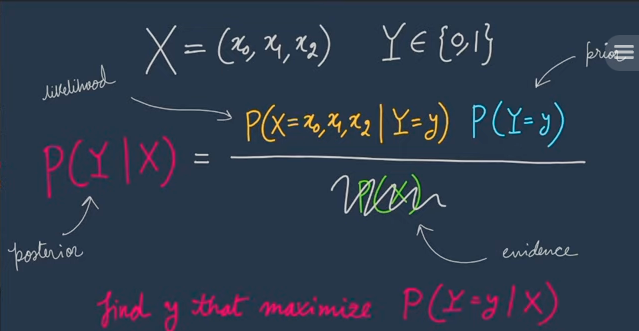

## <font color='blue'> Naive Bayes Classifier Uygulama</font>

In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

In [58]:
data = pd.read_csv("Breast_cancer_data.csv")
data.head(10)

,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,diagnosis
0,17.99,10.38,122.80,1001.0,0.11840,0
1,20.57,17.77,132.90,1326.0,0.08474,0
2,19.69,21.25,130.00,1203.0,0.10960,0
3,11.42,20.38,77.58,386.1,0.14250,0
4,20.29,14.34,135.10,1297.0,0.10030,0
5,12.45,15.70,82.57,477.1,0.12780,0
6,18.25,19.98,119.60,1040.0,0.09463,0
7,13.71,20.83,90.20,577.9,0.11890,0
8,13.00,21.82,87.50,519.8,0.12730,0
9,12.46,24.04,83.97,475.9,0.11860,0


**Bu datasetinde tüm featurelar continuous. Naive Bayes classifier modeller için bu iyi bir şey değil. Bunu çözmek için featureları kategorik değerlere çevirebiliriz veya approximate distribution fit edebiliriz.**

### <font color='green'>**1. Target değişkenimizin nasıl dağıldığına bakıyoruz.**</font>

<AxesSubplot: >

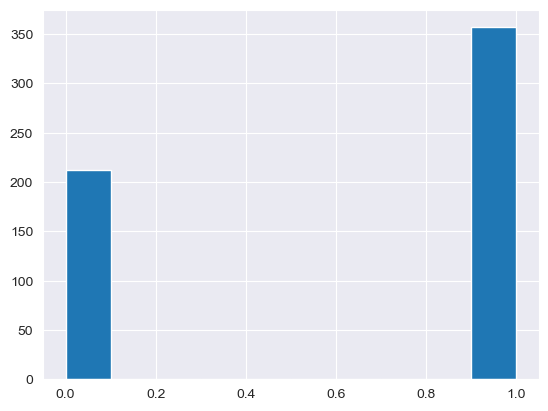

In [59]:
data['diagnosis'].hist()

**1'lerin 0'lardan daha fazla olduğunu görüyoruz. Data bir ölçüde unbalanced.**

### <font color='green'>**2. Featureların independent olup olmadığına bakıyoruz. Dependent olanları datadan çıkartıyoruz.**</font>

**Naive bayesi uygulayabilmemiz için featureların birbirlerinden bağımsız olması gerekiyor. Independent olup olmadığını anlamak için heatmap çizdiriyoruz. Bu matriste her bir hücre correlation skor bilgisini veriyor. Burada pearson correlation skorunu kullandık.**

<AxesSubplot: >

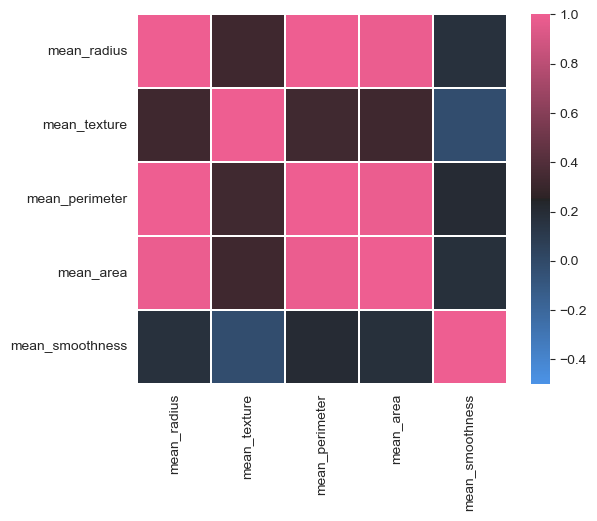

In [60]:
# target haricindeki sütunların birbirleriyle korelasyonuna baktık.

corr = data.iloc[:,:-1].corr(method='pearson')
cmap = sns.diverging_palette(250, 354, 80, 60, center = 'dark', as_cmap=True)
sns.heatmap(corr, vmax=1, vmin = -.5, cmap = cmap, square = True, linewidths=.2)

**Çok fazla pozitif korelasyon olduğunu görüyoruz. Sezgisel olarak da radius'un perimeter ve area featurelarıyla dependent olmasını bekleriz, burada da ikili korelasyon değerlerinin çok yüksek olduğunu görüyoruz. Aynı datada bunların bir arada olmaması gerekiyor. Diğer ikili korelasyonların görece daha düşük.**

**Radius, area, peremeter üçlüsünden sadece radiusu bırakıyoruz datada.**

In [61]:
data = data[['mean_radius','mean_texture','mean_smoothness','diagnosis']]
data.head()

,mean_radius,mean_texture,mean_smoothness,diagnosis
0,17.99,10.38,0.11840,0
1,20.57,17.77,0.08474,0
2,19.69,21.25,0.10960,0
3,11.42,20.38,0.14250,0
4,20.29,14.34,0.10030,0


### <font color='green'>**3. Featurelarımızın histogramını çiziyoruz.**</font>

**Bunu yapmamızın nedeni continuous değişkenlerle baş edebilmek için kullandığımız yöntemlerden biri approximate distribution fit etmekti. Bu yüzden featurelarımızın dağılımlarını kontrol ediyoruz.**

<AxesSubplot: xlabel='mean_texture', ylabel='Count'>

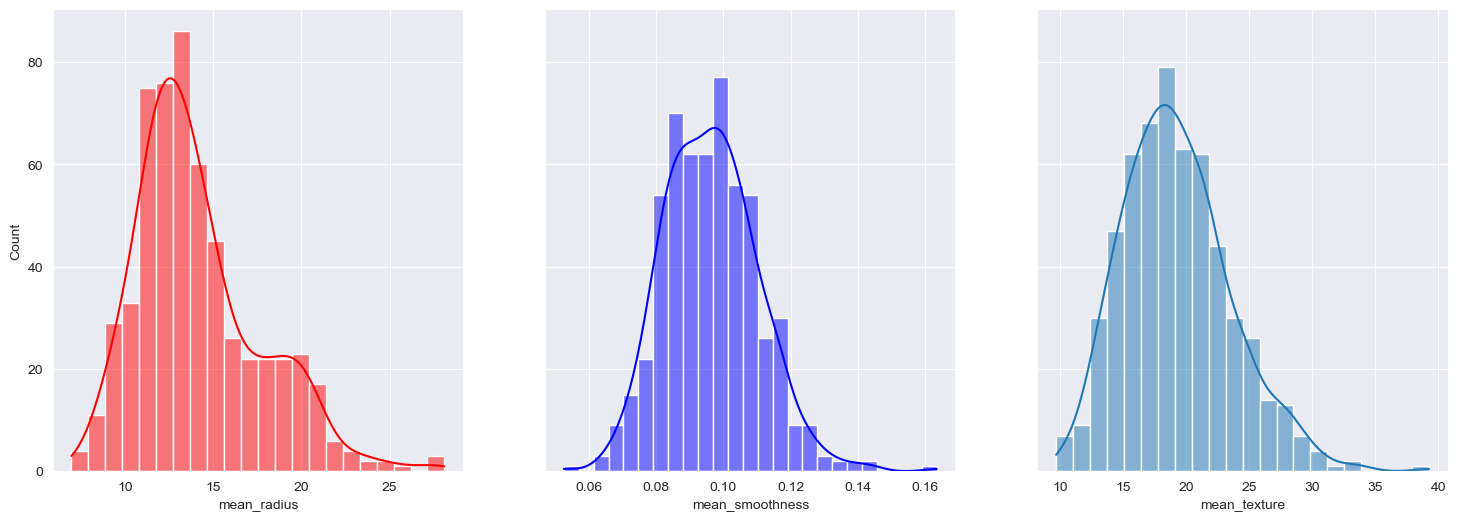

In [62]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
sns.histplot(data, ax=axes[0], x="mean_radius", kde=True, color='r')
sns.histplot(data, ax=axes[1], x="mean_smoothness", kde=True, color='b')
sns.histplot(data, ax=axes[2], x="mean_texture", kde=True)

**mean_smoothness ve mean_texture'a baktığımızda dağılımlarının normal dağılıma yakın olduğunu görüyoruz. Rahatlıkla söyleyebiliriz ki bu featureların dağılımlarını normal dağılıma fit edebiliriz. mean_radius'un dağılımı normal dağılıma çok yakın değil fakat bu feature için de normal dağılımı fit edeceğiz.** 

### <font color='green'>**4. Veriyi Bir Dağılıma Fit Ederek Continuous Verilerden Kurtulma**</font>

**Bayes teoremindeki hesaplamaları yapıyoruz.**

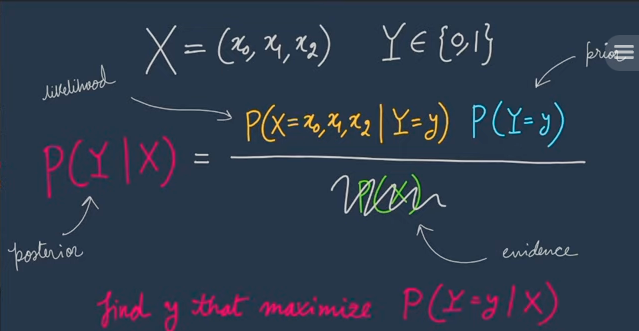

#### <font color='purple'>**1. Tüm y classları için (0,1) P(Y=y) olasılık hesaplamalarını yapıyoruz.**</font>

In [63]:
# sorted(list(data['diagnosis'].unique()))

In [64]:
def calculate_prior(df, Y):
    classes = sorted(list(df[Y].unique()))
    
    prior = []
    for e in classes:
        prior.append(len(df[df[Y]==e])/len(df))
        
    return prior

In [48]:
# calculate_prior(data,'diagnosis')

#### <font color='purple'>**2. Normal dağılımı kullanarak likelihood hesaplaması yapıyoruz.**</font>

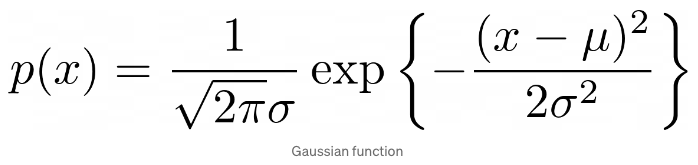

In [38]:
# feat = list(data.columns)

In [37]:
# df_0 = data[data['diagnosis']==0] # belirli bir y değeri filtreliyorum. 

In [42]:
# df_0.head()

In [43]:
# bu y değeri olduğunda x'in mean radius olma olasılığını hesaplıyorum. Bunun için direkt normal dağılımın formülünü kullandık.

# mean, std = df_0['mean_radius'].mean(), df_0['mean_radius'].std()
# p_x_given_y = (1 / (np.sqrt(2 * np.pi) * std)) *  np.exp(-((17.99-mean)**2 / (2 * std**2 )))

In [44]:
# p_x_given_y

In [82]:
# y = 0 olduğunda radius'un 17.99 olma olasılığı

def calculate_likelihood_gaussian(df, feat_name, feat_val, Y, label):
    
    feat = list(df.columns)
    df = df[df[Y]==label]
    mean, std = df[feat_name].mean(), df[feat_name].std()
    p_x_given_y = (1 / (np.sqrt(2 * np.pi) * std)) *  np.exp(-((feat_val-mean)**2 / (2 * std**2 )))
    
    return p_x_given_y

#### <font color='purple'>**3. Tüm y değerleri için formüldeki pay değerini hesaplıyoruz. `P(X=x1|Y=y)P(X=x2|Y=y)...P(X=xn|Y=y) * P(Y=y)`**</font>
**Likelihood hesabı yaparken her bir feature için ayrı ayrı hesaplama yapıyoruz. Çünkü en baştan featureların independent olduğunu kabul ettik.**

In [83]:
def naive_bayes_gaussian(df, X, Y):
    
    # featureların adlarını alıyoruz.
    features = list(df.columns)[:-1] 

    # calculate prior
    prior = calculate_prior(df, Y) #1 

    Y_pred = [] # 2 
    
    # 3 
    for row in X:
        labels = sorted(list(df[Y].unique())) # 4
        likelihood = [1]*len(labels) # 5
        
        for j in range(len(labels)): # 6
            for i in range(len(features)): # 7
                likelihood[j] *= calculate_likelihood_gaussian(df, features[i], row[i], Y, labels[j]) # 8 

        # pay'daki değeri hesaplıyoruz.
        post_prob = [1]*len(labels) # 9
        for j in range(len(labels)):
            post_prob[j] = likelihood[j] * prior[j]

        Y_pred.append(np.argmax(post_prob)) # 10

    return np.array(Y_pred) # 11

- 1: ilgili y değerinin olasılığı P(Y=y). [0.37258347978910367, 0.6274165202108963]
- 2: predictionlarımızın olacağı boş bir array yarattık.
- 3: datamızdaki her bir row için çalıştırıyoruz bu loopu. Baştan sonra tüm işlemleri tek bir row için düşün önce.
- 4: [0,1]
- 5: [1,1] # çarparken en başta 1 ile çarpmak için oluşturduk.
- 6: Tüm y değerleri için de çalıştırıyoruz.
- 7: Her bir feature için likelihood hesaplayacağız.
- 8: Her bir feature'da ilgili x değerinin gerçekleşme olasılığını hesaplıyoruz. 
    (df,'radius',row[0],'diagnosis', 0). Bu fonksiyonda df girdikten sonra labela göre filtreleniyor. Dolayısıyla datayı Y değerinin 0 olduğu satırlar olarak düşünebilirsin. 0 olduğu satırlarda mean, std vs. hesaplanıp y=0 olduğunda bu x değerinin gelme olasılığı hesaplanıyor. likelihood[j] = likelihood[0] = 1 ilk başta. Y değerinin 0 olduğu durumlar için likelihoodu hesapladığımızda [1,1] ilk indeksteki 1 değerini güncellemiş oluyoruz.
- 9: En başta 1 değerini veriyoruz iki indeste de. Daha sonra güncelliyoruz.
- 10: Hangi indexteki daha büyükse o indeks değerini veriyor. 
- 11: Her bir row için tek bir değer hesaplayıp Y_pred'in içine attık. En son array olarak dönüyoruz. 

#### <font color='purple'>**4. Modelimizi test ediyoruz.**</font>

**traindeki (df) y değerlerinin olasılık değerlerini (prior) almış olduk. trainin (df) mean, std değerlerine göre testteki her bir rowun likelihoodunu hesapladık. X_testteki her bir rowun hangi classa ait olduğunu tahmin ettik.**

In [84]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size=.2, random_state=41)

X_test = test.iloc[:,:-1].values
Y_test = test.iloc[:,-1].values
Y_pred = naive_bayes_gaussian(train, X=X_test, Y="diagnosis")

**Sonuçlara bakıyoruz.**

In [86]:
from sklearn.metrics import confusion_matrix, f1_score

print(confusion_matrix(Y_test, Y_pred))
print(f1_score(Y_test, Y_pred))

[[36  4]
 [ 0 74]]
0.9736842105263158


- False Negative (0 diyip de yanlış bulduklarım) **0** çıkmış.
- False Positive (1 diyip de yanlış bulduklarım) **4 adet** çıkmış.
- True Positive (1 diyip de doğru bulduklarım) **36 adet** çıkmış.
- True Negative (0 diyip de doğru bulduklarım) **74 adet** çıkmış.

### <font color='green'>**5. Continuous Değişkenleri Kategorik Değişkenlere Çevirerek Continuous Değerlerden Kurtulma**</font>

**Pandas'ın `cut` fonksiyonunu kullanarak verileri 3 kategoriye ayırdık.**

In [65]:
data.head()

,mean_radius,mean_texture,mean_smoothness,diagnosis
0,17.99,10.38,0.11840,0
1,20.57,17.77,0.08474,0
2,19.69,21.25,0.10960,0
3,11.42,20.38,0.14250,0
4,20.29,14.34,0.10030,0


In [66]:
data["cat_mean_radius"] = pd.cut(data["mean_radius"].values, bins = 3, labels = [0,1,2])
data["cat_mean_texture"] = pd.cut(data["mean_texture"].values, bins = 3, labels = [0,1,2])
data["cat_mean_smoothness"] = pd.cut(data["mean_smoothness"].values, bins = 3, labels = [0,1,2])

# continuous olan sütunları siliyoruz. 
data = data.drop(columns=["mean_radius","mean_texture","mean_smoothness"]) 

data = data[["cat_mean_radius","cat_mean_texture","cat_mean_smoothness","diagnosis"]]

In [67]:
data.head()

,cat_mean_radius,cat_mean_texture,cat_mean_smoothness,diagnosis
0,1,0,1,0
1,1,0,0,0
2,1,1,1,0
3,0,1,2,0
4,1,0,1,0


**Bayes teoremindeki hesaplamaları yapıyoruz.**

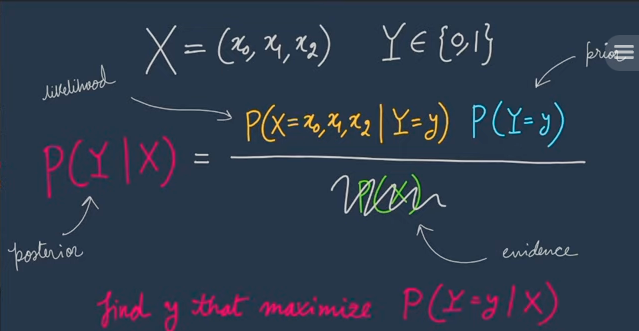

#### <font color='purple'>**1. Tüm y classları için (0,1) P(Y=y) olasılık hesaplamalarını yapıyoruz.**</font>

In [68]:
# öncekisiyle aynı

def calculate_prior(df, Y):
    classes = sorted(list(df[Y].unique()))
    
    prior = []
    for e in classes:
        prior.append(len(df[df[Y]==e])/len(df))
        
    return prior

In [69]:
calculate_prior(data,'diagnosis')

[0.37258347978910367, 0.6274165202108963]

#### <font color='purple'>**2. Likelihood hesaplaması P(X=x|Y=y) yapıyoruz.**</font>

In [70]:
# Y = 0 olduğunda x'in 1 olma olasılığı

In [71]:
# data2 = data.copy()

In [73]:
# data2_0 = data2[data2['diagnosis'] == 0]

In [78]:
# # Bu datada cat_mean_radius'un 0 olma olasılığı
# len(data2_0[data2_0['cat_mean_radius']==0])/len(data2_0)

In [79]:
# bunu her bir feature'ın her bir değeri (0,1,2) için hesaplayıp birbirleriyle çarpacağım. 

In [80]:
def calculate_likelihood_categorical(df, feat_name, feat_val, Y, label):
    feat = list(df.columns)
    df = df[df[Y]==label]
    p_x_given_y = len(df[df[feat_name]==feat_val])/len(df)
    return p_x_given_y

#### <font color='purple'>**3. Tüm y değerleri için formüldeki pay değerini hesaplıyoruz. `P(X=x1|Y=y)P(X=x2|Y=y)...P(X=xn|Y=y) * P(Y=y)`**</font>

**Önceki fonksiyonla aynı**

In [81]:
def naive_bayes_categorical(df, X, Y):
    
    # featureların adlarını alıyoruz.
    features = list(df.columns)[:-1]

    # calculate prior
    prior = calculate_prior(df, Y)

    Y_pred = []
    # loop over every data sample
    
    for x in X:
        labels = sorted(list(df[Y].unique()))
        likelihood = [1]*len(labels)
        for j in range(len(labels)):
            for i in range(len(features)):
                likelihood[j] *= calculate_likelihood_categorical(df, features[i], x[i], Y, labels[j])

        # calculate posterior probability (numerator only)
        post_prob = [1]*len(labels)
        for j in range(len(labels)):
            post_prob[j] = likelihood[j] * prior[j]

        Y_pred.append(np.argmax(post_prob))

    return np.array(Y_pred) 

#### <font color='purple'>**4. Modelimizi test ediyoruz.**</font>

In [82]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size=.2, random_state=41)

X_test = test.iloc[:,:-1].values
Y_test = test.iloc[:,-1].values
Y_pred = naive_bayes_categorical(train, X=X_test, Y="diagnosis")

In [83]:
from sklearn.metrics import confusion_matrix, f1_score

print(confusion_matrix(Y_test, Y_pred))
print(f1_score(Y_test, Y_pred))

[[38  2]
 [ 5 69]]
0.9517241379310345


**Burada f1 skorunun önceki modele göre düşük olduğunu görüyoruz. Verileri kategorik hale getirirken eşit bir şekilde böldük. Bu en optimal yol olmayabilir.**